# Imports

In [1]:
import mitsuba as mi
import drjit as dr
import numpy as np
from mitsuba.scalar_rgb import Transform4f as T
from matplotlib import pyplot as plt

# Settings

In [2]:
mi.set_variant("llvm_ad_rgb")

In [3]:
spp = 32
seed = 0

In [4]:
key = 'sensor.principal_point_offset_x'

# Scene

In [5]:
integrator = {
    'type': 'path',
    'max_depth': 6
}

camera_sensor = {
        'type': 'perspective',
        'fov_axis': 'smaller',
        'near_clip': 0.001,
        'far_clip': 100.0,
        'focus_distance': 1000.0,
        'fov': 60.0,
        'principal_point_offset_x': 0.0,
        'to_world': T().look_at(
                        origin=(0, 0, 3.0),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'sampler': {
            'type': 'independent',
            'sample_count': 128
        },
        'film': {
            'type': 'hdrfilm',
            'width': 128,
            'height': 128,
            'rfilter': { 'type': 'tent' },
            'pixel_format': 'rgb',
            'component_format': 'float32'
        }
    }

scene = mi.load_dict({
    'type': 'scene',
    'integrator': integrator,
    'sensor': camera_sensor,

'gray': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.85, 0.85, 0.85) }
},
'white': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.885809, 0.698859, 0.666422) }
},
'green': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.105421, 0.37798, 0.076425) }
},
'red': {
    'type': 'diffuse',
    'reflectance': { 'type': 'rgb', 'value': (0.570068, 0.0430135, 0.0443706) }
},

'light': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_luminaire.obj',
    'to_world': T().translate([0, -0.01, 0]),
    'bsdf': { 'type': 'ref', 'id': 'white' },
    'emitter': {
        'type': 'area',
        'radiance': { 'type': 'rgb', 'value': (18.387, 13.9873, 6.75357) }
    }
},

'floor': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_floor.obj',
    'bsdf': { 'type': 'ref', 'id': 'white' }
},
'ceiling': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_ceiling.obj',
    'bsdf': { 'type': 'ref', 'id': 'white' }
},
'back': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_back.obj',
    'bsdf': { 'type': 'ref', 'id': 'white' }
},
'greenwall': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_greenwall.obj',
    'bsdf': { 'type': 'ref', 'id': 'green' },
},
'redwall': {
    'type': 'obj',
    'filename': 'scenes/meshes/cbox_redwall.obj',
    'bsdf': { 'type': 'ref', 'id': 'red' }
},

'bunny': {
    'type': 'ply',
    'filename': 'scenes/meshes/bunny.ply',
    'to_world': T().scale(6),
    'bsdf': {
        'type': 'diffuse',
        'reflectance': { 'type': 'rgb', 'value': (0.3, 0.3, 0.75) }
    }
},
})

params = mi.traverse(scene)

# Reference

In [6]:
img_ref = mi.render(scene, params, spp=spp, seed=seed)
mi.util.convert_to_bitmap(img_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

# Initialization

In [7]:
opt = mi.ad.Adam(lr=0.0001)

initial_value = mi.Float(0.1)

opt[key] = initial_value
params[key] = initial_value

params.update()

img_init = mi.render(scene, params, spp=spp, seed=seed)
mi.util.convert_to_bitmap(img_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

# AD Optimization

In [8]:
def mse(image):
    return dr.mean(dr.square(image - img_ref))

In [9]:
iterations = 100
loss_hist = []
ad_grads = []
fd_grads = []

params.update(opt)

for it in range(iterations):
    original_param = mi.TensorXf(params[key])
    
    # ---------- AD ----------
    img = mi.render(scene, params, spp=spp, seed=seed)
    loss = mse(img)

    loss_hist.append(loss)
    dr.backward(loss)
    ad_grad = dr.grad(params[key])
    ad_grads.append(ad_grad[0])
    opt.step()

    # ------------------------


    # ---------- FD ----------
    with dr.suspend_grad():
        epsilon = 1e-4
        params[key] = mi.TensorXf(original_param) + epsilon
        params.update()
        img_plus = mi.render(scene, params, spp=spp, seed=seed)
        loss_plus = mse(img_plus)

        params[key] = mi.TensorXf(original_param) - epsilon
        params.update()
        img_minus = mi.render(scene, params, spp=spp, seed=seed)
        loss_minus = mse(img_minus)

        fd_grad = (loss_plus - loss_minus) / (2 * epsilon)
        fd_grads.append(fd_grad)

    # ------------------------

    params.update(opt)

    print(f"Iteration {it:02d}: loss = {loss}, grad_diff = {ad_grad[0] - fd_grad}", end='\r')

    

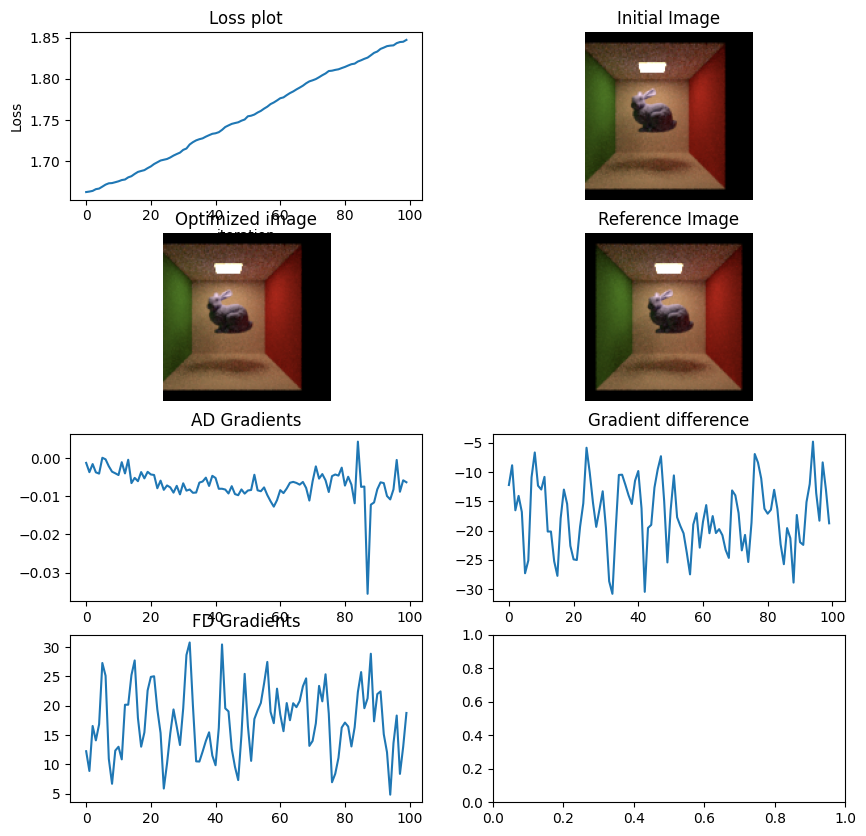

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

loss_hist_np = [np.array(x) for x in loss_hist]

ad_grads_np = []
fd_grads_np = []
grad_difference = []
for i in range(len(ad_grads)):
    ad_grad_np = np.array(ad_grads[i])
    fd_grad_np = np.array(fd_grads[i])
    ad_grads_np.append(ad_grad_np)
    fd_grads_np.append(fd_grad_np)
    grad_difference.append(ad_grad_np-fd_grad_np)

axs[0][0].plot(loss_hist_np)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Loss plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, spp=spp, seed=seed)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');

axs[2][0].plot(ad_grads_np)
axs[2][0].set_title('AD Gradients');

axs[2][1].plot(grad_difference)
axs[2][1].set_title('Gradient difference');

axs[3][0].plot(fd_grads_np)
axs[3][0].set_title('FD Gradients');

# FD Optimization

In [11]:
params[key] = initial_value
params.update()
img_init = mi.render(scene, params, spp=spp, seed=seed)
mi.util.convert_to_bitmap(img_init)


Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

In [12]:
loss_hist_2 = []

for it in range(iterations):
    original_param = mi.TensorXf(params[key])

    img = mi.render(scene, params, spp=spp, seed=seed)
    loss = mse(img)

    loss_hist_2.append(loss)
    
    epsilon = 1e-4
    params[key] = mi.TensorXf(original_param) + epsilon
    params.update()
    img_plus = mi.render(scene, params, spp=spp, seed=seed)
    loss_plus = mse(img_plus)

    params[key] = mi.TensorXf(original_param) - epsilon
    params.update()
    img_minus = mi.render(scene, params, spp=spp, seed=seed)
    loss_minus = mse(img_minus)

    fd_grad = (loss_plus - loss_minus) / (2 * epsilon)

    params[key] -= 0.0001*fd_grad
    params.update()

    print(f"Iteration {it:02d}: loss = {loss}, grad_diff = {ad_grad[0] - fd_grad}", end='\r')

    

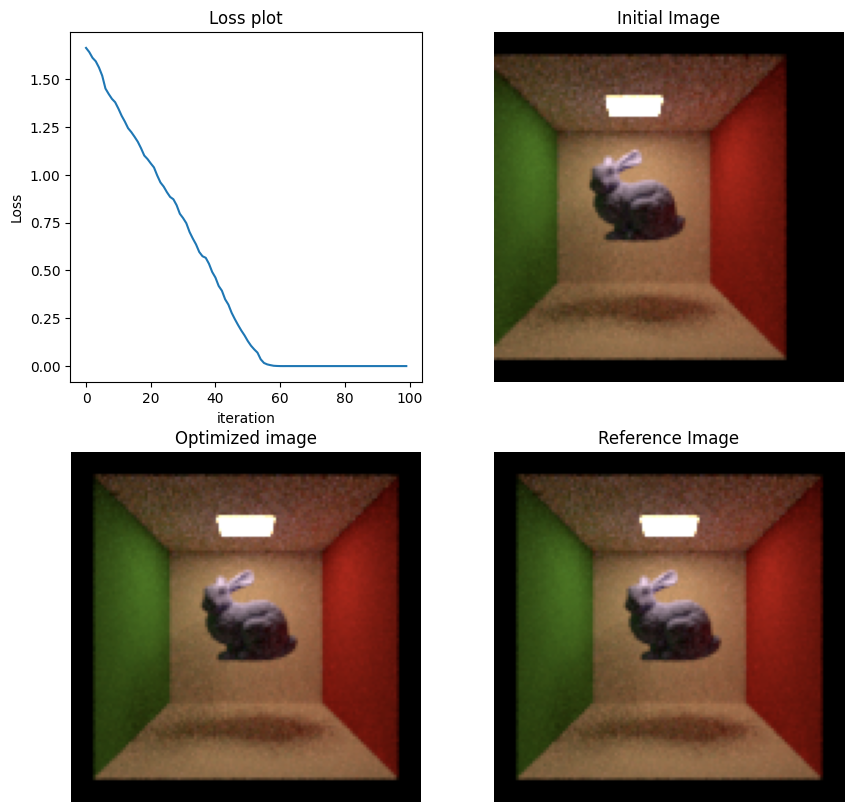

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

loss_hist_2_np = [np.array(x) for x in loss_hist_2]

axs[0][0].plot(loss_hist_2_np)
axs[0][0].set_xlabel('iteration');
axs[0][0].set_ylabel('Loss');
axs[0][0].set_title('Loss plot');

axs[0][1].imshow(mi.util.convert_to_bitmap(img_init))
axs[0][1].axis('off')
axs[0][1].set_title('Initial Image')

axs[1][0].imshow(mi.util.convert_to_bitmap(mi.render(scene, params, spp=spp, seed=seed)))
axs[1][0].axis('off')
axs[1][0].set_title('Optimized image')

axs[1][1].imshow(mi.util.convert_to_bitmap(img_ref))
axs[1][1].axis('off')
axs[1][1].set_title('Reference Image');